In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from runner import run_coverage_test, plot_coverage, plot_coverage_by_dim
from inverse_problem_setup import make_inverse_problem, summarize_setup, get_forward_model
from Gaussian import Gaussian
from LinGaussTest import LinGaussInvProb, LinGaussTest

In [2]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind') # whitegrid
sns.set_context("paper", font_scale=1.5)

In [3]:
# color scheme for plots
from types import SimpleNamespace

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

# Inverse Problem Setup

Linear Gaussian inverse problem with a forward model defined as the composition of a linear convolution with a 
sub-sampling observation operator.

In [5]:
rng = np.random.default_rng(532124)

# inverse problem
d = 100
ker_length = 21
ker_lengthscale = 20
sig = 0.2
s = 4 # every sth index is observed

# misspecified model
ker_lengthscale_mispec = 2

# surrogate
Q_scale_factor = 1.0

# experiment
n_reps = 100

## Visualize Experiment Setup Before Running Full Test

The underlying statistical model is
$$
\begin{align}
y \mid u &\sim \mathcal{N}(Gu, \Sigma) \\
u &\sim \mathcal{N}(m_0, C_0)
\end{align}
$$

The random surrogate model which replaces $Gu$ is $G_\star u \sim \mathcal{N}(Gu + r, Q)$ with
fixed bias $r$ and surrogate covariance $Q$.

### Well-specified model
In this example the observed data is simulated exactly from the above model. The surrogate is 
calibrated in the sense that the bias $r$ is chosen by sampling from $\mathcal{N}(0, Q)$.

In [6]:
# Well-specified inverse problem
inv_prob_info = make_inverse_problem(rng=rng, 
                                     d=d, 
                                     noise_sd=sig, 
                                     ker_length=ker_length, 
                                     ker_lengthscale=ker_lengthscale,
                                     s=s)
inv_prob, g_conv_true, grid, idx_obs = inv_prob_info

# Calibrated surrogate model
Q = Q_scale_factor * inv_prob.G @ inv_prob.prior.cov @ inv_prob.G.T
test = LinGaussTest(inv_prob, Q)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

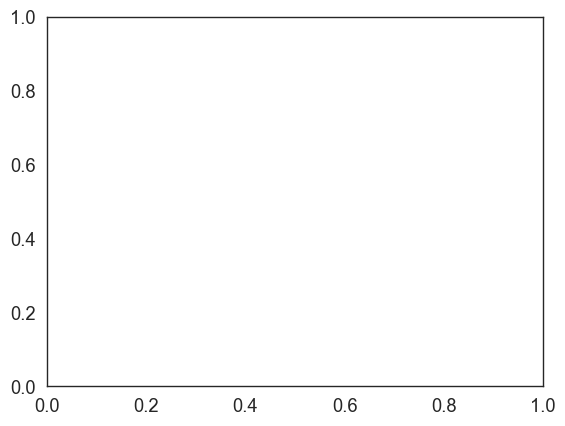

In [7]:
summarize_setup(inv_prob, test, grid, idx_obs, g_conv_true)

### Model Misspecification
We now consider modifying the above problem so that the likelihood $\mathcal{N}(y \mid Gu, \Sigma)$ is 
misspecified. In particular, we consider the same data generating process as above but now solve the 
inverse problem with a misspecified $G$, where the smoothing lengthscale of $G$ is misspecified.

In [ ]:
# Misspecified inverse problem model
mispec_model = get_forward_model(d, ker_length, ker_lengthscale_mispec, s, Q_scale_factor)
G_mispec = mispec_model[0]

inv_prob_mispec = LinGaussInvProb(rng=rng,
                                  G=G_mispec,
                                  m0=inv_prob.prior.mean,
                                  C0=inv_prob.prior.cov,
                                  Sig=inv_prob.noise.cov,
                                  y=inv_prob.y)

# Calibrated surrogate model
test_mispec = LinGaussTest(inv_prob_mispec, Q)

In [ ]:

fig_exact, ax_exact = plot_exact_post(inv_prob, grid, idx_obs, colors=colors, 
                                      title='exact posterior', alpha_prior=0.1, 
                                      alpha_post=0.3)

ax_exact.get_legend().remove()
display(fig_exact)
plt.close()

In [ ]:
fig_surrogate, ax_surrogate = plot_surrogate(inv_prob, test, grid, idx_obs, colors)

ax_surrogate.get_legend().remove()
display(fig_surrogate)

In [ ]:
summarize_setup(inv_prob, test_mispec, grid, idx_obs, g_conv_true)

## Analytical Analysis

In [8]:
from analytical_analysis import (
    plot_eigenvalue_comparison,
    plot_mean_comparison,
    lambda_exact,
    lambda_eup,
    lambda_ep,
    alpha_exact,
    alpha_eup,
    alpha_ep,
)

In [9]:
# settings for analytical analysis
c0 = 1.0
r = 2.5
q_over_sig_max = 8.0

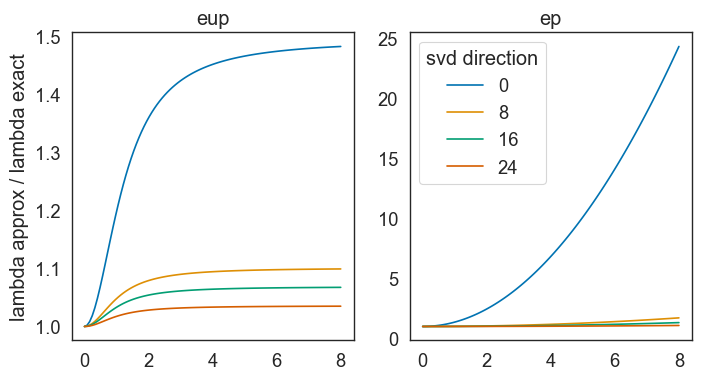

In [10]:
# small sigma
sig = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_small_sig, ax_small_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                         sig=sig, 
                                                         s_idcs=None, 
                                                         q_vals=q_vals)


ax_small_sig[0].set_prop_cycle(None)
ax_small_sig[1].set_prop_cycle(None)
ax_small_sig[0].set_xlabel(None)
ax_small_sig[1].set_xlabel(None)
fig_small_sig.savefig('out/experiment1_svd_lambda.png', bbox_inches='tight')
display(fig_small_sig)
plt.close()

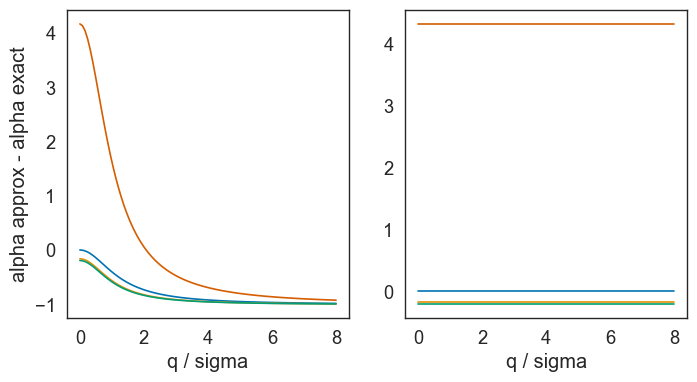

In [11]:
sig = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_mean, ax_mean = plot_mean_comparison(G=test.G, 
                                         y=test.y, 
                                         r=test.e.mean, 
                                         q_vals=q_vals, 
                                         c0=c0, 
                                         sig=sig,
                                         s_idcs=None)

ax_mean[0].set_prop_cycle(None) # ensure colors align with eigenvalue plots
ax_mean[1].set_prop_cycle(None)
ax_mean[0].set_title(None)
ax_mean[1].set_title(None)
ax_mean[1].get_legend().remove()
fig_mean.savefig('out/experiment1_svd_alpha.png', bbox_inches='tight')
display(fig_mean)
plt.close()

## Run Experiment over Replications

In [12]:
import pickle

In [18]:
tests, res, probs = run_coverage_test(rng, n_reps, m0=inv_prob.prior.mean, 
                                      C0=inv_prob.prior.cov, Sig=inv_prob.noise.cov, 
                                      G=inv_prob.G, Q_true=Q, Q=Q, include_mcmc=True)

with open('out/experiment_results.pkl', 'wb') as f:
    pickle.dump((res, probs), f)

Replication 1
Replication 2
Replication 3
Replication 4
Replication 5
Replication 6
Replication 7
Replication 8
Replication 9
Replication 10
Replication 11
Replication 12
Replication 13
Replication 14
Replication 15
Replication 16
Replication 17
Replication 18
Replication 19
Replication 20
Replication 21
Replication 22
Replication 23
Replication 24
Replication 25
Replication 26
Replication 27
Replication 28
Replication 29
Replication 30
Replication 31
Replication 32
Replication 33


: 

In [ ]:
coverage_list = [
    res['cover']['mean_cover_joint'],
    res['cover']['eup_cover_joint'],
    res['cover']['ep_cover_joint']
]

fig_cover, ax_cover = plot_coverage(coverage_list, 
                                    probs=probs, 
                                    labels=['mean', 'eup', 'ep'],
                                    colors=colors,
                                    q_min=0.05, 
                                    q_max=0.95)


fig_cover.savefig('out/experiment1_coverage.png', bbox_inches='tight')
display(fig_cover)

# Surrogate Model

In [ ]:
# Construct Q so that trace(Q) = trace(Sig) (doubling total variance)
tr_Sig = np.trace(inv_prob.noise.cov)
q_floor = 1e-6
q_start = np.max(np.diag(inv_prob.noise.cov))
q = np.array([max(q_floor, q_start/2**i) for i in range(n)])
q_vars = tr_Sig * q / q.sum()

plt.semilogy(q_vars)
plt.show()

In [ ]:
"""
U, s, Vh = np.linalg.svd(inv_prob.G)

# High noise in stable directions
Q_stable = (U*q_vars) @ U.T

# High noise in unstable directions
Q_unstable = (U*q_vars[::-1]) @ U.T

# Noise proportional to prior pushforward
Q_prior = 0.5 * G @ inv_prob.prior.cov @ G.T

# All error in first left singular vector direction
idx = 0
u1 = U[idx,:]
eps = 1e-6
scaler = np.sum(s)
Q1 = 5 * scaler * np.linalg.outer(u1, u1) + eps * np.identity(inv_prob.n)
"""

In [ ]:
res['mcmc']

In [ ]:
u_samp = inv_prob.prior.sample()
g_samp = inv_prob.G @ u_samp

r_samp = Gaussian(rng=rng, cov=Q1).sample()
g_samp_perturbed = g_samp + r_samp

plt.plot(grid, u_samp, color="black", label="u_true")
plt.plot(idx_obs, g_samp, color="orange", label="g_true")
plt.plot(idx_obs, g_samp_perturbed, color="red", label="g_true + r")
plt.legend()
plt.show()

In [ ]:
c0 = 1.0
r = 0
q_over_sig_max = 10.0

In [ ]:
c0 = 1.0
r = 0
q_over_sig_max = 10.0

# small sigma
sig = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_small_sig, ax_small_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                         sig=sig, 
                                                         s_idcs=None, 
                                                         q_vals=q_vals)

# large sigma
sig = 10.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_big_sig, ax_big_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                     sig=sig, 
                                                     s_idcs=None, 
                                                     q_vals=q_vals)

display(fig_small_sig)
display(fig_big_sig)
plt.close()

In [ ]:
# TODO: some other options:
# - Fix sig and vary ratio r/q

# small bias
r = -0.1
sig = 1.0 
q_vals = np.linspace(0, sig * q_over_sig_max, num=100)
fig_mean_small_r, ax_mean_small_r = plot_mean_comparison(G=test.G, y=test.y, r=r, 
                                                         q_vals=q_vals, 
                                                         c0=c0, sig=sig,
                                                         s_idcs=None)
# ax_mean_small_r[0].plot(q_vals/sig, np.abs(r/q_vals), color='r', linestyle='-')

# big bias
r = -10.0
sig = 10.0 
q_vals = np.linspace(0, sig * q_over_sig_max, num=100)
fig_mean_big_r, ax_mean_big_r = plot_mean_comparison(G=test.G, y=test.y, r=r, 
                                                     q_vals=q_vals, 
                                                     c0=c0, sig=sig,
                                                     s_idcs=None)

display(fig_mean_small_r)
display(fig_mean_big_r)

In [ ]:
# Fixing ratio r/q [so emulator is always calibrated] and varying 
# q/sigma.

sig = 1.0 
r_over_q = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
r_vals = q_vals.copy()
nq = len(q_vals)
nr = nq

In [ ]:
U, s, Vh = np.linalg.svd(G)
ns = len(s)
s_idcs = np.arange(0, len(s), len(s) // 3)
y = test.y.copy()

alphas_exact = alpha_exact(s=s, y=y, U=U, c0=c0, sig=sig)
alphas_eup_norm = np.empty((nr, nq, ns))
alphas_ep_norm = np.empty((nr, nq, ns))

for i, r in enumerate(r_vals):
    alphas_eup = alpha_eup(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_ep = alpha_ep(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_eup_norm[i] = alphas_eup - alphas_exact
    alphas_ep_norm[i] = alphas_ep - alphas_exact

